# AutoGrad

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Motivation - Basic Derivatives

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

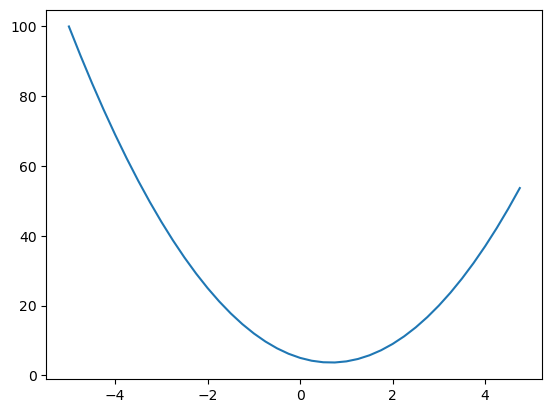

In [3]:
xs = np.arange(-5,5,0.25) # vals from [-5, 5) step size 0.25
ys = f(xs)
plt.plot(xs, ys)

Instead of using symbolic approach for calculating derivatives we can using the limit formula that states that slope/derivate at x: L = lim h->0 ((f(x+h) - f(x)))/h 

In [4]:
h = 0.0001 # this tends to zero
x = 3
L = ((f(x+h)-f(x)))/h
print(L)
# taking the derivate of f(x) : f'(x) = 6x - 4, so f(3) = 14

14.000300000063248


#### Considering multiple variables

In [5]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [6]:
h = 0.0001
# input vals
a = 2.0
b = -3.0
c = 10.0

# # for a
# d1 = a*b + c
# a += h
# d2 = a*b + c
# print('d1 ', d1)
# print('d2 ', d2)
# print('slope ', (d2-d1)/h)

# # for b
# d1 = a*b + c
# b += h
# d2 = a*b + c
# print('d1 ', d1)
# print('d2 ', d2)
# print('slope ', (d2-d1)/h)

# for c
d1 = a*b + c
c += h
d2 = a*b + c
print('d1 ', d1)
print('d2 ', d2)
print('slope ', (d2-d1)/h)

d1  4.0
d2  4.0001
slope  0.9999999999976694


### Building the Value class

In [14]:
class Value:

    def __init__(self, data):
        self.data = data
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
a = Value(2.0)
b = Value(-3.0)
a,b

(Value(data=2.0), Value(data=-3.0))

#### Adding `add` functionality

In [8]:
class Value:

    def __init__(self, data):
        self.data = data
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data) 
        return out
    
a = Value(2.0)
b = Value(-3.0)
a + b # this internally calls a.__add__(b)

Value(data=-1.0)

#### Adding `multiply` functionality

In [9]:
class Value:

    def __init__(self, data):
        self.data = data
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data) 
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data) 
        return out
    
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
a*b + c
# (a.__mul__(b)).__add__(c) # equivalent (uncomment to verify)

Value(data=4.0)

#### Making `expression graphs` and keeping track of children of each expression as well as operation used to generate that expression and labels

In [27]:
class Value:

    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') 
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, {self, other}, '*') 
        return out
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
e = a*b; e.label = 'e'
c = Value(10.0, label='c')
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [28]:
d._prev
# d = (a.__mul__(b)).__add__(c)
# (a.__mul__(b)) --> had _prev has 2, -3
# so d has _prev as -6 (a*b), 10

{Value(data=-6.0), Value(data=10.0)}

In [29]:
d._op
# as d was produced by the addition of the two values

'+'

#### Adding visualisation using graphviz to understand the expression graph / tree

In [30]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes = set(); edges = set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR -> left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f}" % (n.label, n.data), shape = 'record') # for value in the graph create a record for it
        if n._op:
            # if this node is the result of an operation then we create a node to signify it
            dot.node(name = uid + n._op, label = n._op)
            # and connect node to it
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

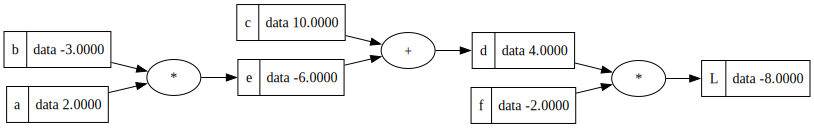

In [31]:
draw_dot(L)

#### Adding `Gradients` to this Value to be able to backpropagate from the final output

In [68]:
class Value:

    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0.0 # intialized to zero as we assume intially that every value does not impact the final output
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') 
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, {self, other}, '*') 
        return out
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
e = a*b; e.label = 'e'
c = Value(10.0, label='c')
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [5]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes = set(); edges = set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR -> left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record') # for value in the graph create a record for it
        if n._op:
            # if this node is the result of an operation then we create a node to signify it
            dot.node(name = uid + n._op, label = n._op)
            # and connect node to it
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

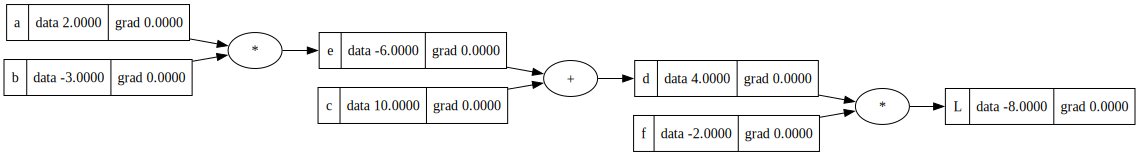

In [70]:
draw_dot(L)

In [71]:
def lol(): # this numerically verifies the derivative of L wrt to a variable using limits

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    e = a*b; e.label = 'e'
    c = Value(10.0, label='c')
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    # wrt to a --> dL/da
    a = Value(2.0+h, label='a')
    b = Value(-3.0, label='b')
    e = a*b; e.label = 'e'
    c = Value(10.0, label='c')
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data

    # wrt to L --> dL/dL
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    e = a*b; e.label = 'e'
    c = Value(10.0, label='c')
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L3 = L.data+h

    # wrt to d --> dL/dd
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    e = a*b; e.label = 'e'
    c = Value(10.0, label='c')
    d = e + c; d.label='d'
    d.data += h
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L4 = L.data

    # wrt to f --> dL/df
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    e = a*b; e.label = 'e'
    c = Value(10.0, label='c')
    d = e + c; d.label='d'
    f = Value(-2.0+h, label='f')
    L = d*f; L.label = 'L'
    L5 = L.data

    # wrt to c --> dL/dc
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    e = a*b; e.label = 'e'
    c = Value(10.0+h, label='c')
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L6 = L.data

    # wrt to e --> dL/de
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    e = a*b; e.label = 'e'; e.data += h
    c = Value(10.0, label='c')
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L7 = L.data

    # wrt to e --> dL/de
    a = Value(2.0, label='a')
    b = Value(-3.0+h, label='b')
    e = a*b; e.label = 'e';
    c = Value(10.0, label='c')
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L8 = L.data

    return ((L8-L1)/h), ((L7-L1)/h), ((L6-L1)/h), ((L5-L1)/h), ((L4-L1)/h), ((L3-L1)/h), ((L2-L1)/h)

In [72]:
dL_db, dL_de, dL_dc, dL_df, dL_dd, dL_dL, dL_da = lol()
print(f"dL/da = {dL_da}")
print(f"dL/db = {dL_db}")
print(f"dL/dc = {dL_dc}")
print(f"dL/de = {dL_de}")
print(f"dL/dd = {dL_dd}")
print(f"dL/df = {dL_df}")
print(f"dL/dL = {dL_dL}")

dL/da = 6.000000000000227
dL/db = -3.9999999999995595
dL/dc = -1.9999999999988916
dL/de = -2.000000000000668
dL/dd = -2.000000000000668
dL/df = 3.9999999999995595
dL/dL = 1.000000000000334


In [73]:
# we can set dL/dL as 1
L.grad = 1.0

# L = d*f
# => dL/df = d
# => dL/dd = f

f.grad = d.data # (4.0)
d.grad = f.data # (-2.0)

'''
WANT:
dL/dc

KNOW:
dL/dd and dd/dc

CHAIN RULE:
dL/dc = dL/dd * dd/dc

d = c + e 
L = (c+e) * f
dd/dc = 1 + de/dc (=0)
dL/dd = f
dL/dc = f * 1
using chain rule to calculate the impact of a local node on the final output
also
dd/de = 1
dL/de = f
through `+` derivate just get propagated ---> IMPORTANT NOTE
'''
c.grad = -2.0 # f.data (dL/dd)
e.grad = -2.0 # f.data (dL/dd)

'''
dL/da = dL/dd * dd/de * de/da
de/da = b
de/db = a
dL/da = (f) * (1) * (b)
dL/db = (f) * (1) * (a)
'''

a.grad = 6.0 # f.data * b.data
b.grad = -4.0 # f.data * a.data

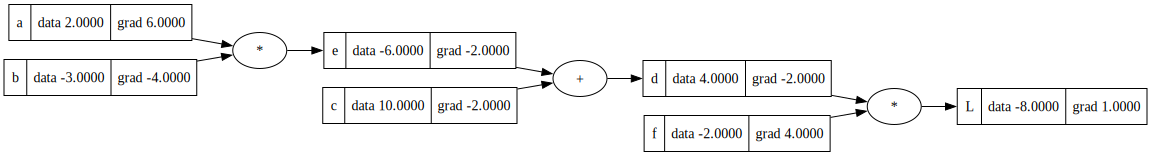

In [74]:
draw_dot(L)

#### Taking one step in the direction of gradient to increase the value of `L` i.e. a single optimization step

In [75]:
a.data += a.grad * 0.01
b.data += b.grad * 0.01
c.data += c.grad * 0.01
f.data += f.grad * 0.01
e = a*b
d = e + c
L = d*f
L

Value(data=-7.286496)

### Implementing backprop through a `neuron`

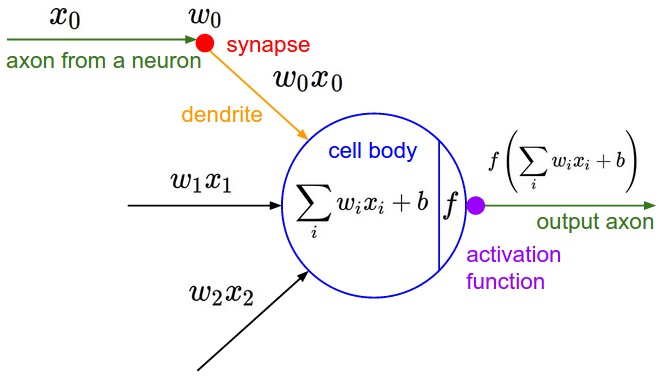

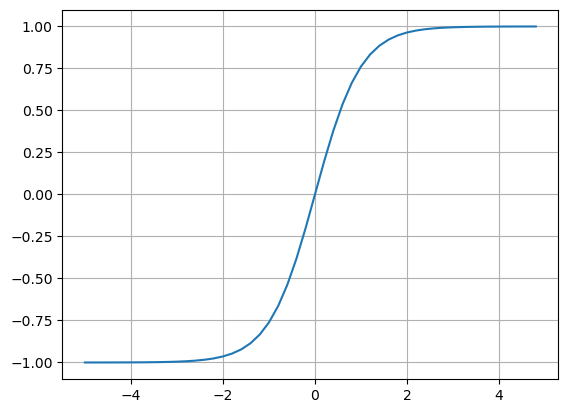

In [76]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

#### we need to implement tanh = (e^2x - 1)/ (e^2x + 1) into our value class

In [79]:
class Value:

    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0.0 # intialized to zero as we assume intially that every value does not impact the final output
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') 
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, {self, other}, '*') 
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        return Value(t, (self, ), 'tanh')

In [101]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


In [102]:
o.grad = 1.0
# o = tanh(n)
# do/dn = 1 - (tanh(n))**2 = 1 - o**2
n.grad = 1 - (o.data)**2
# n = x1*w1+x2*w2 + b --> derivate just propagates
# do/db = do/dn * dn/db = do/dn
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
# x1w1 = x1*w1
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

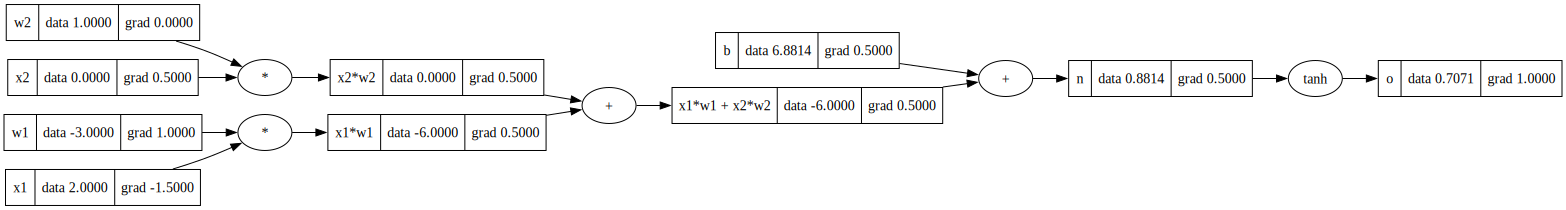

In [103]:
draw_dot(o)

#### Adding backward function to calculate gradients at any node to `Value Class`

In [47]:
class Value:

    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad # doing += as gradients accumulate in case a node is used more than once
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, {self, other}, '*') 
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

In [33]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [ ]:
o.grad = 1
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

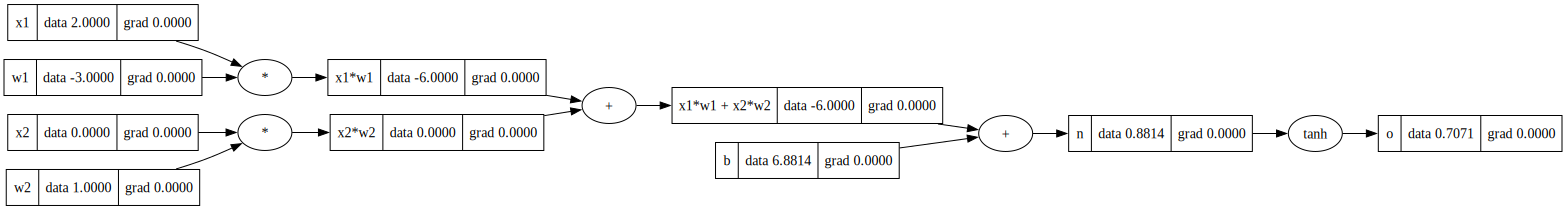

In [16]:
draw_dot(o)

#### Adding automatic gradient calculation and backpropagation by using topological sorting to the `Value` Class

In [35]:
# o.grad = 1.0
# topo = []
# vis = set()
# def build_topo(v):
#     if v not in vis:
#         vis.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
#     return

# build_topo(o)

# for node in reversed(topo):
#     node._backward()

In [48]:
class Value:

    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, {self, other}, '*') 
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        vis = set()
        def build_topo(v):
            if v not in vis:
                vis.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
            return
        self.grad = 1.0
        build_topo(self)
        for node in reversed(topo):
            node._backward()

In [49]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [50]:
o.backward()

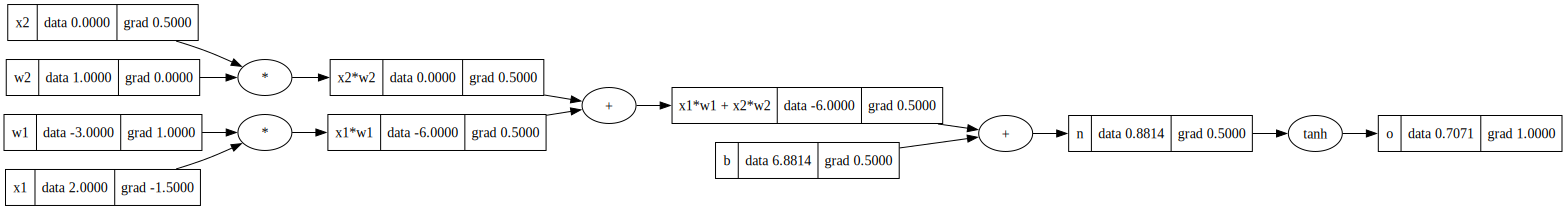

In [51]:
draw_dot(o)